In [1]:
import sys

In [2]:
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.2+cu102.html
!{sys.executable} -m pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.2+cu102.html
!{sys.executable} -m pip install torch-geometric
!{sys.executable} -m pip install ray
!{sys.executable} -m pip install "ray[tune]"
!{sys.executable} -m pip install -Uqq ipdb

Looking in links: https://data.pyg.org/whl/torch-1.10.2+cu102.html
Looking in links: https://data.pyg.org/whl/torch-1.10.2+cu102.html


In [3]:
module_path = "/home/ec2-user/SageMaker/sb-rec-system"
if module_path not in sys.path:
    sys.path.append(module_path)

from algorithms.srgnn_benchmark.srgnn.model import *
import ipdb
import matplotlib.pyplot as plt

In [4]:
def train(config):
    model = SRGNN(config["hidden_dim"], config["num_items"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config["lr"],
                                 weight_decay=config["l2_penalty"])

    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=config["step"],
                                          gamma=config["weight_decay"])
    
    train_dataset = GraphDataset('/home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/data/diginetica', 'train')


    train_loader = pyg_data.DataLoader(train_dataset,
                                       batch_size=config["batch_size"],
                                       shuffle=False,
                                       drop_last=False)
    
    val_dataset = GraphDataset('/home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/data/diginetica', 'test')


    val_loader = pyg_data.DataLoader(val_dataset,
                                     batch_size=config["batch_size"],
                                     shuffle=False,
                                     drop_last=False)
    # Train
    losses = []
    test_accs = []
    test_mrr = []
    top_k_accs = []
    top_k_mrrs = []

    best_acc = 0
    best_model = None

    for epoch in range(config["epochs"]):
        total_loss = 0
        model.train()
        for _, batch in enumerate(tqdm(train_loader)):
            batch.to('cpu')
            optimizer.zero_grad()

            pred = model(batch)
            label = batch.y
            loss = criterion(pred, label)

            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs

        total_loss /= len(train_loader.dataset)
        losses.append(total_loss)

        scheduler.step()

    checkpoint_dir = '/home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/trained_models'
    path = os.path.join(checkpoint_dir, f"srgnn_diginetica")
    torch.save(model.state_dict(), path)

In [5]:
#best config settings from hyper param search
config={
    'l2_penalty': 1e-05, 
    'lr': 0.001, 
    'epochs': 10, 
    'batch_size': 100, 
    'hidden_dim': 100, 
    'step': 3, 
    'weight_decay': 0.1,
    'num_items': 43098
}

In [ ]:
train(config)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
  0%|          | 0/7195 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 28%|██▊       | 1987/7195 [05:18<13:53,  6.25it/s]

100%|██████████| 720/720 [00:51<00:00, 14.01it/s]


The MRR@20 : 0.10758342224228748 HitRate@20 : 0.22089871711120687
Hitrate: 7.2972222222222225 MRR@: 0.10758342224228748


100%|██████████| 720/720 [00:48<00:00, 14.95it/s]


The MRR@20 : 0.144104131637128 HitRate@20 : 0.39595813585000067
Hitrate: 7.836111111111111 MRR@: 0.144104131637128


100%|██████████| 720/720 [00:51<00:00, 13.88it/s]


The MRR@20 : 0.15828187828362825 HitRate@20 : 0.4603249614299415
Hitrate: 8.169444444444444 MRR@: 0.15828187828362825


100%|██████████| 720/720 [00:47<00:00, 15.10it/s]


The MRR@20 : 0.17476786447446596 HitRate@20 : 0.49070843815586473
Hitrate: 9.219444444444445 MRR@: 0.17476786447446596


100%|██████████| 720/720 [00:47<00:00, 15.01it/s]


The MRR@20 : 0.17661263768450902 HitRate@20 : 0.49839465161855256
Hitrate: 9.229166666666666 MRR@: 0.17661263768450902


100%|██████████| 720/720 [00:48<00:00, 14.74it/s]


The MRR@20 : 0.17770548721303406 HitRate@20 : 0.5025226903137031
Hitrate: 9.258333333333333 MRR@: 0.17770548721303406


100%|██████████| 720/720 [00:47<00:00, 15.17it/s]


The MRR@20 : 0.17882377840213695 HitRate@20 : 0.5034956287267016
Hitrate: 9.330555555555556 MRR@: 0.17882377840213695


100%|██████████| 720/720 [00:47<00:00, 15.05it/s]


The MRR@20 : 0.17922340279389015 HitRate@20 : 0.5041488873754292
Hitrate: 9.3625 MRR@: 0.17922340279389015


100%|██████████| 720/720 [00:47<00:00, 15.07it/s]


The MRR@20 : 0.1795110736514574 HitRate@20 : 0.5048994398654565
Hitrate: 9.380555555555556 MRR@: 0.1795110736514574


100%|██████████| 720/720 [00:48<00:00, 14.82it/s]


The MRR@20 : 0.1794432088369832 HitRate@20 : 0.5050801284278705
Hitrate: 9.368055555555555 MRR@: 0.1794432088369832
test_accs : 9.380555555555556, top_k_accs : 0.5050801284278705, top_k_mrrs : 0.1794432088369832
Maximum test set accuracy: 9.380555555555556
Minimum loss: 4.726984682426485


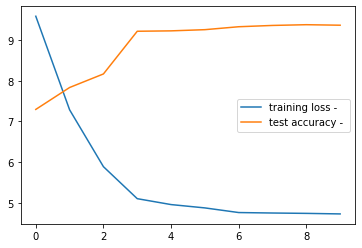

In [12]:
test_accs, top_k_accs, top_k_mrrs, losses, best_model, best_acc, test_loader = train(config) 

print(f'test_accs : {max(test_accs)}, top_k_accs : {max(top_k_accs)}, top_k_mrrs : {top_k_mrrs}')
print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

plt.plot(losses, label="training loss" + " - ")
plt.plot(test_accs, label="test accuracy" + " - ")
plt.legend()
fig = plt.gcf()
fig.savefig('train_loss_test_acc_diginetica.pdf')
plt.show()

In [24]:
mrr20 = [0.10758342224228748, 0.144104131637128, 0.15828187828362825, 0.17476786447446596, 0.17661263768450902, 0.17770548721303406,  0.17882377840213695, 0.17922340279389015, 0.1795110736514574]
hit20 = [0.22089871711120687,
 0.39595813585000067,
 0.4603249614299415,
 0.49070843815586473,
 0.49839465161855256,
 0.5025226903137031,
 0.5034956287267016,
 0.5041488873754292,
 0.5048994398654565,
 0.5050801284278705]

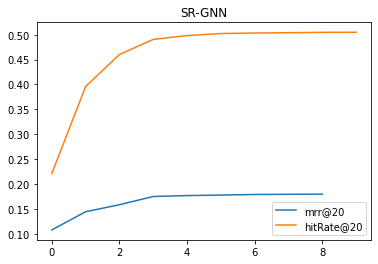

In [28]:
plt.plot(mrr20, label="mrr@20")
plt.plot(hit20, label="hitRate@20")
plt.legend()
plt.title('SR-GNN')
f = plt.gcf()
f.savefig("srgnn_mrr@20_hitrate@20_validation_set.pdf")
plt.show()

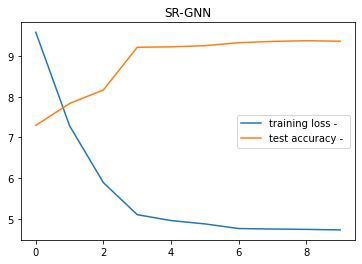

In [31]:
plt.plot(losses, label="training loss" + " - ")
plt.plot(test_accs, label="test accuracy" + " - ")
plt.legend()
plt.title('SR-GNN')
f = plt.gcf()
f.savefig("srgnn_training_loss_test_acc_validation_set.pdf")
plt.show()